<a href="https://colab.research.google.com/github/rounakburman/cs666student/blob/main/Copy_of_CS666_Assignment_6_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

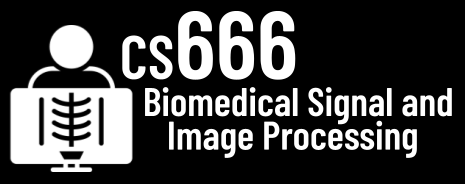
# Assignment 6

In [2]:
# NAME: Rounak Burman

In [3]:
# In this assignment, we will explore the new Segment-Anything-Model (https://segment-anything.com/)
# for the task of mitochondria detection in a connectomics dataset acquired using electron microscopy.
#
# We will run the following experiments:
#
# 1. Using the Segment-Anything-Model (SAM) without seeds in auto mode
#
# 2. Train a U-Net classifier from scratch
#
# 3. Evaluate the U-Net classifier
#
# 4. Use the U-Net to seed the SAM model (U-Net + SAM)
#
# 5. Compare U-Net vs. U-Net + SAM
#
# Bonus: Improve U-Net + SAM

In [4]:
### IMPORTANT (DO THIS RIGHT AWAY!) ###
#
# Activate GPU support: Runtime -> Change Runtime Type
# Hardware Accelerator: GPU
#
### IMPORTANT ###

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# We will use mahotas as well!
!pip install mahotas --no-binary :all:
import mahotas as mh

DEPRECATION: --no-binary currently disables reading from the cache of locally built wheels. In the future --no-binary will not influence the wheel cache. pip 23.1 will enforce this behaviour change. A possible replacement is to use the --no-cache-dir option. You can use the flag --use-feature=no-binary-enable-wheel-cache to test the upcoming behaviour. Discussion can be found at https://github.com/pypa/pip/issues/11453
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# And of course, we need the data!
!wget https://cs666.org/data/mito.npz

--2023-04-25 02:43:06--  https://cs666.org/data/mito.npz
Resolving cs666.org (cs666.org)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to cs666.org (cs666.org)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37610178 (36M) [application/octet-stream]
Saving to: ‘mito.npz.1’

mito.npz.1          100%[===================>]  35.87M   124MB/s    in 0.3s    

2023-04-25 02:43:07 (124 MB/s) - ‘mito.npz.1’ saved [37610178/37610178]



## 0. Data loading (5 points)

In [8]:
# The data includes images and manually segmented masks.
loaded = np.load('mito.npz')
images = loaded['arr_0'][0]
masks = loaded['arr_0'][1]

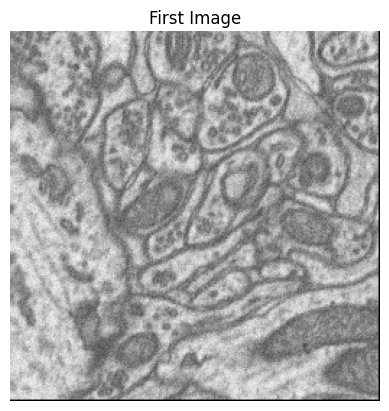

In [9]:
# TODO: Show the first image with the gray colormap.
# TODO: YOUR_CODE
import matplotlib.pyplot as plt

# Show the first image with the gray colormap
plt.imshow(images[0], cmap='gray')
plt.title("First Image")
plt.axis("off")
plt.show()

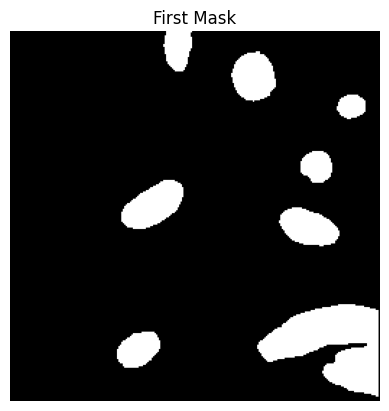

In [10]:
# TODO: Show the first mask.
plt.imshow(masks[0], cmap='gray')
plt.title("First Mask")
plt.axis("off")
plt.show()

## 1. SAM in AUTO mode (15 points)

In [11]:
# We will use the METASEG package as an easy-to-use layer
# for SAM.
!pip install metaseg==0.6.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
# SAM comes in two modes, auto and with seeds
from metaseg import SegAutoMaskPredictor, SegManualMaskPredictor

In [13]:
# SAM takes files as input!
# So we have to store the numpy array to disk.
mh.imsave('first.png', images[0])

In [14]:
#
# Run SAM in auto mode on first.png and store
# the result as first_output.png.
#
results = SegAutoMaskPredictor().image_predict(
    source="first.png",
    model_type="vit_l", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="first_output.png",
    show=False,
    save=True,
)

vit_l model already exists as 'vit_l.pth'. Skipping download.


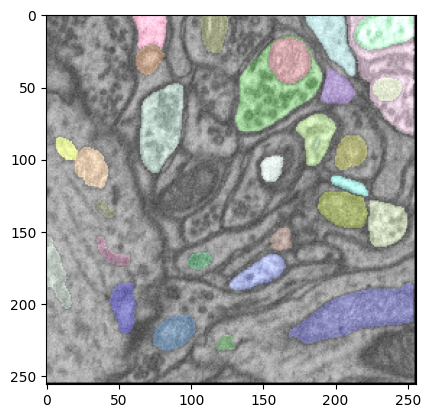

In [15]:
imshow( mh.imread('first_output.png') )

In [16]:
# TODO: Does SAM work well for mitochondria detection?
# TODO: Yes, based on the results, SAM works well for mitochondria detection.

In [17]:
# TODO: Try the auto predictor on your image!
# 
# Please upload your own image and test how well
# the auto mode of SAM performs!
#
# Run SAM in auto mode on that image and store
# the result as second_output.png. Show the output!
#

vit_h model already exists as 'vit_h.pth'. Skipping download.


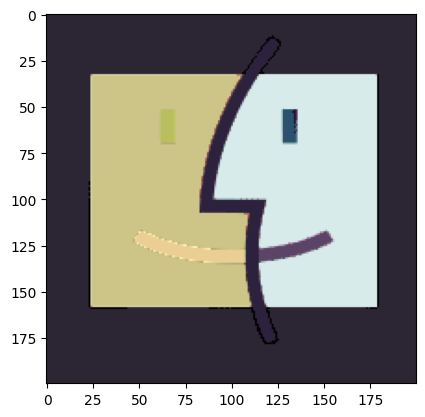

In [18]:
# TODO: YOUR CODE
results2 = SegAutoMaskPredictor().image_predict(
    source="Macos_200x200.png",
    model_type="vit_h", # vit_l, vit_h, vit_b
    points_per_side=16, 
    points_per_batch=64,
    min_area=0,
    output_path="second_output.png",
    show=False,
    save=True,
)
imshow( mh.imread('second_output.png') )

In [19]:
# TODO: Does SAM work well on your example?
# TODO: The segmentation seems to work good enough

## 2. Train a U-Net classifier from scratch (50 points)


In [20]:
# We will use the keras_unet package!
#
# HINT: There is documentation available here, if you are stuck during this part
# of the assignment: https://github.com/karolzak/keras-unet
!pip install keras_unet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
# keras_unet has convenience functions to visualize data
from keras_unet.utils import plot_imgs

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


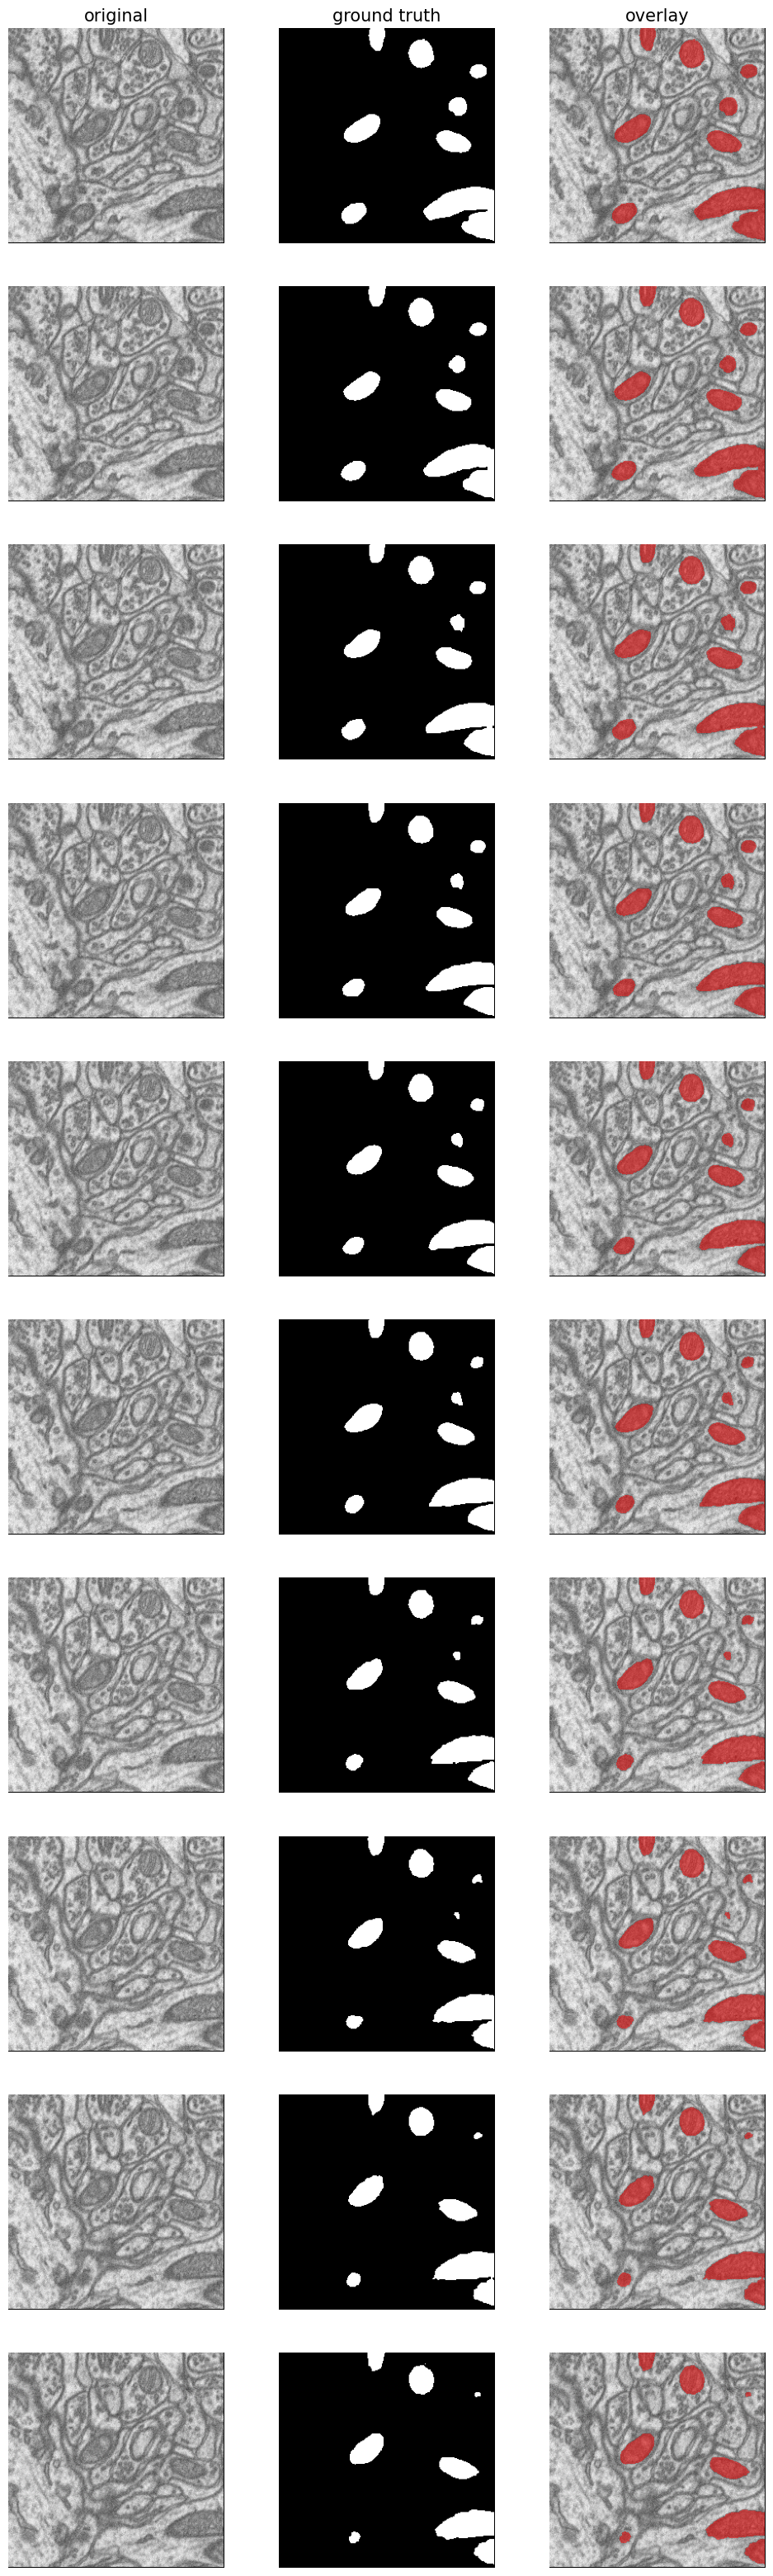

In [22]:
# Let's plot a few images and masks.
plot_imgs(org_imgs=images, mask_imgs=masks)

In [23]:
# The images are in this format.
print( images.shape, images.max(), images.dtype )

(660, 256, 256) 243 uint8


In [24]:
# TODO convert the format to the following:
# (660, 256, 256, 1) 1.0 float32
#
# 1) convert to float32
# 2) normalize to the range of 0..1
# 3) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# X = 
X = images.astype(np.float32)
X /= X.max()
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
print(X.shape, X.max(), X.dtype)

(660, 256, 256, 1) 1.0 float32


In [25]:
# Validate that everything matches accordingly
print( X.shape, X.max(), X.dtype )

(660, 256, 256, 1) 1.0 float32


In [26]:
# The masks are in this format.
print( masks.shape, masks.max(), masks.dtype )

(660, 256, 256) 255 uint8


In [27]:
# TODO convert the format to the following:
# (660, 256, 256, 1) True bool
#
# 1) convert to bool
# 2) Add the last channel using .reshape like in class
#
# TODO: YOUR_CODE
# y = 
y = images.astype(bool)
y = y.reshape(660,256,256,1)

In [28]:
# Validate that everything matches accordingly
print( y.shape, y.max(), y.dtype )

(660, 256, 256, 1) True bool


In [29]:
#
# Now we will create our train/val/test splits using scikit-learn!
#
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=0)

In [32]:
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_val: ", X_val.shape)
print("y_val: ", y_val.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (369, 256, 256, 1)
y_train:  (369, 256, 256, 1)
X_val:  (159, 256, 256, 1)
y_val:  (159, 256, 256, 1)
X_test:  (132, 256, 256, 1)
y_test:  (132, 256, 256, 1)


In [33]:
# TODO: Why do we call train_test_split twice?
# TODO: We call train_test_split twice in this case to create three separate datasets: a training set, a validation set, and a test set. These datasets are used for different purposes when training and evaluating a machine learning model.

In [34]:
#
# We will use keras_unet's built-in data augmentation
# functionality.
#
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [35]:
# TODO: Please explain the code from above.
# TODO: The code above is using the keras_unet library to apply data augmentation to a set of training images and their corresponding masks (ground truth segmentation maps). Data augmentation is a technique used to artificially increase the size of the training dataset by creating new, slightly altered versions of the original images, which helps improve the performance and generalization of the model being trained.

(2, 256, 256, 1) (2, 256, 256, 1)


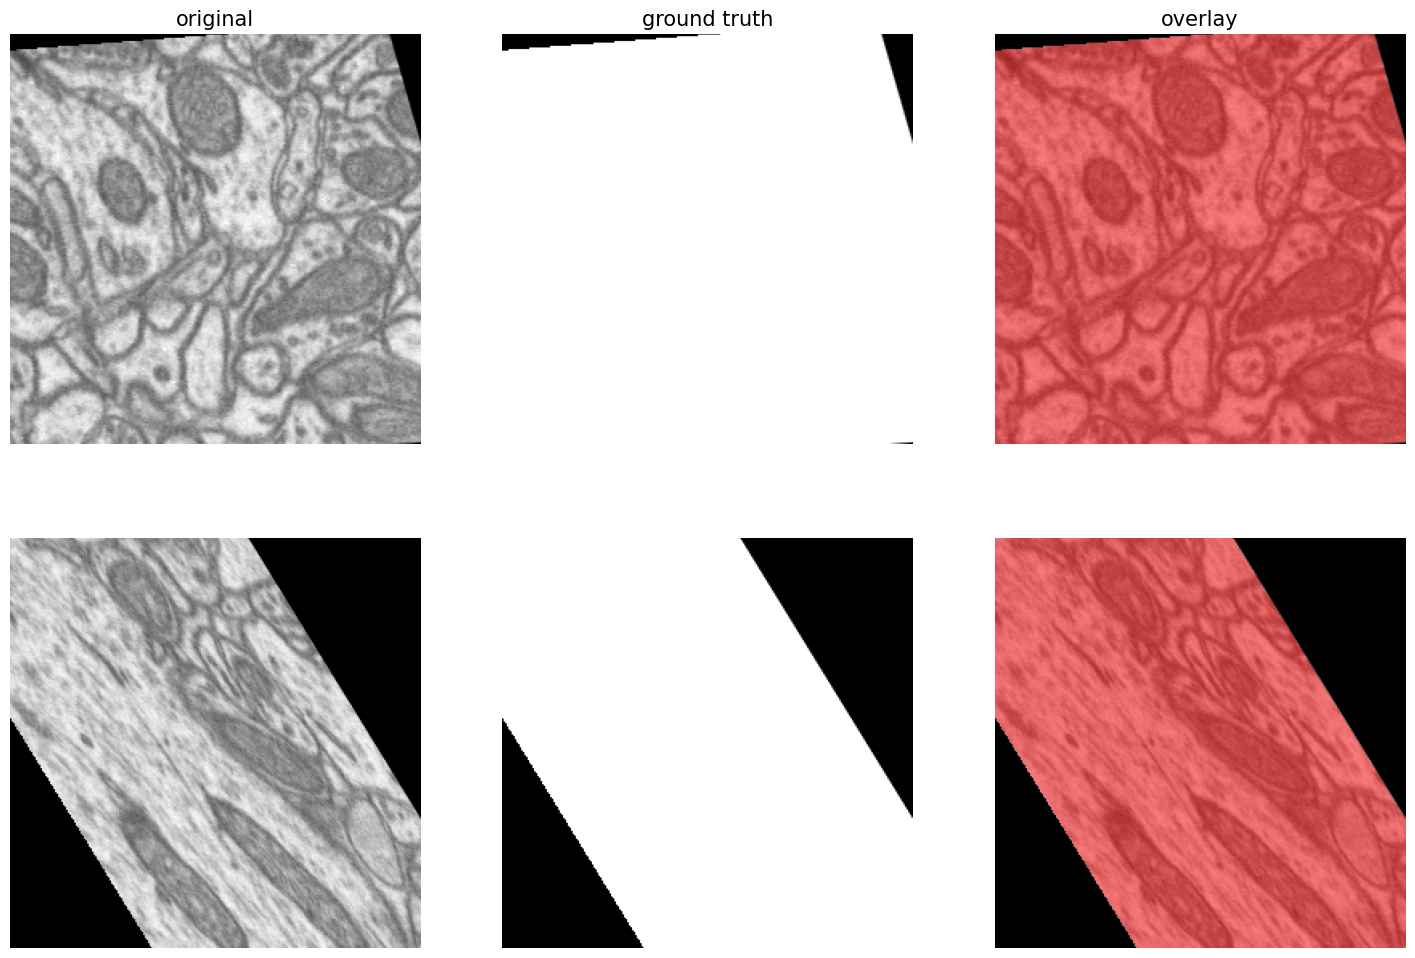

In [36]:
# Run the following code to visualize augmented examples.
sample_batch = next(train_gen)
xx, yy = sample_batch
print(xx.shape, yy.shape)
from keras_unet.utils import plot_imgs

plot_imgs(org_imgs=xx, mask_imgs=yy, nm_img_to_plot=2, figsize=6)

In [37]:
#
# Now, we set up a U-Net classifier.
#
from keras_unet.models import custom_unet

model = custom_unet(
    X_train[0].shape,
    use_batch_norm=False,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid'
)

In [38]:
# TODO: How many  trainable parameters does the model use?
# TODO: 31,030,593
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 spatial_dropout2d (SpatialDrop  (None, 256, 256, 64  0          ['conv2d[0][0]']                 
 out2D)                         )                                                             

In [39]:
#
# Let's compile the model. Please use a LEARNING_RATE of 0.01
# and a MOMENTUM of 0.99.
#
LEARNING_RATE = 0.01
MOMENTUM = 0.99

In [40]:
#
# We will use Stochastic Gradient Descent as optimizer
# and use IoU as a metric.
#
from keras.optimizers import SGD
from keras_unet.metrics import iou, iou_thresholded

model.compile(
    optimizer=SGD(learning_rate=LEARNING_RATE, momentum=MOMENTUM),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [41]:
# TODO: Please explain Intersect-over-Union (IoU) in just a few sentences.
# TODO: A statistic called Intersect-over-Union (IoU) is used to assess how well object detection and segmentation algorithms perform. It calculates the amount of overlap between two areas, such as a ground truth and a forecasted bounding box or mask. The area of the intersection of the two regions is divided by the size of their union to determine the IoU. A value for IoU can be between 0 and 1, with 0 denoting no overlap and 1 denoting a perfect match. Better alignment between the anticipated and ground truth regions is indicated by higher IoU values.

In [44]:
#
# Now let's train the model for 30 epochs!
#
# TODO: Please complete the code below.
# Hint: Don't forget to use the train_gen from above as training data.
# Hint 2: Please don't forget (X_val, y_val) as validation data.
# Hint 3: steps_per_epoch should be set to all of the X_train.
# Hint 4: This will take roughly 30 minutes.
# Hint 5: If you are stuck, look through the repo of keras_unet!
#
history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train),
    epochs=30,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
369/369 [==============================] - 113s 274ms/step - loss: 0.0323 - iou: 0.9823 - iou_thresholded: 0.9874 - val_loss: 0.0044 - val_iou: 0.9968 - val_iou_thresholded: 0.9980
Epoch 2/30
369/369 [==============================] - 59s 158ms/step - loss: 0.0044 - iou: 0.9977 - iou_thresholded: 0.9983 - val_loss: 0.0012 - val_iou: 0.9990 - val_iou_thresholded: 0.9998
Epoch 3/30
369/369 [==============================] - 58s 157ms/step - loss: 0.0027 - iou: 0.9983 - iou_thresholded: 0.9989 - val_loss: 6.4044e-04 - val_iou: 0.9994 - val_iou_thresholded: 1.0000
Epoch 4/30
369/369 [==============================] - 58s 158ms/step - loss: 0.0021 - iou: 0.9986 - iou_thresholded: 0.9991 - val_loss: 5.3694e-04 - val_iou: 0.9995 - val_iou_thresholded: 1.0000
Epoch 5/30
369/369 [==============================] - 58s 158ms/step - loss: 0.0021 - iou: 0.9987 - iou_thresholded: 0.9991 - val_loss: 5.2899e-04 - val_iou: 0.9995 - val_iou_thresholded: 1.0000
Epoch 6/30
369/369 [============

In [45]:
# We can use keras_unet functionality to visualize metrics and loss during training.
from keras_unet.utils import plot_segm_history

plot_segm_history(history)

In [46]:
# TODO: Do these plots look good to you?
# TODO: From my observations, the plots look good enough

## 3. Evaluate U-Net (10 points)

In [47]:
# Let's predict all of X_test
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 1s/step


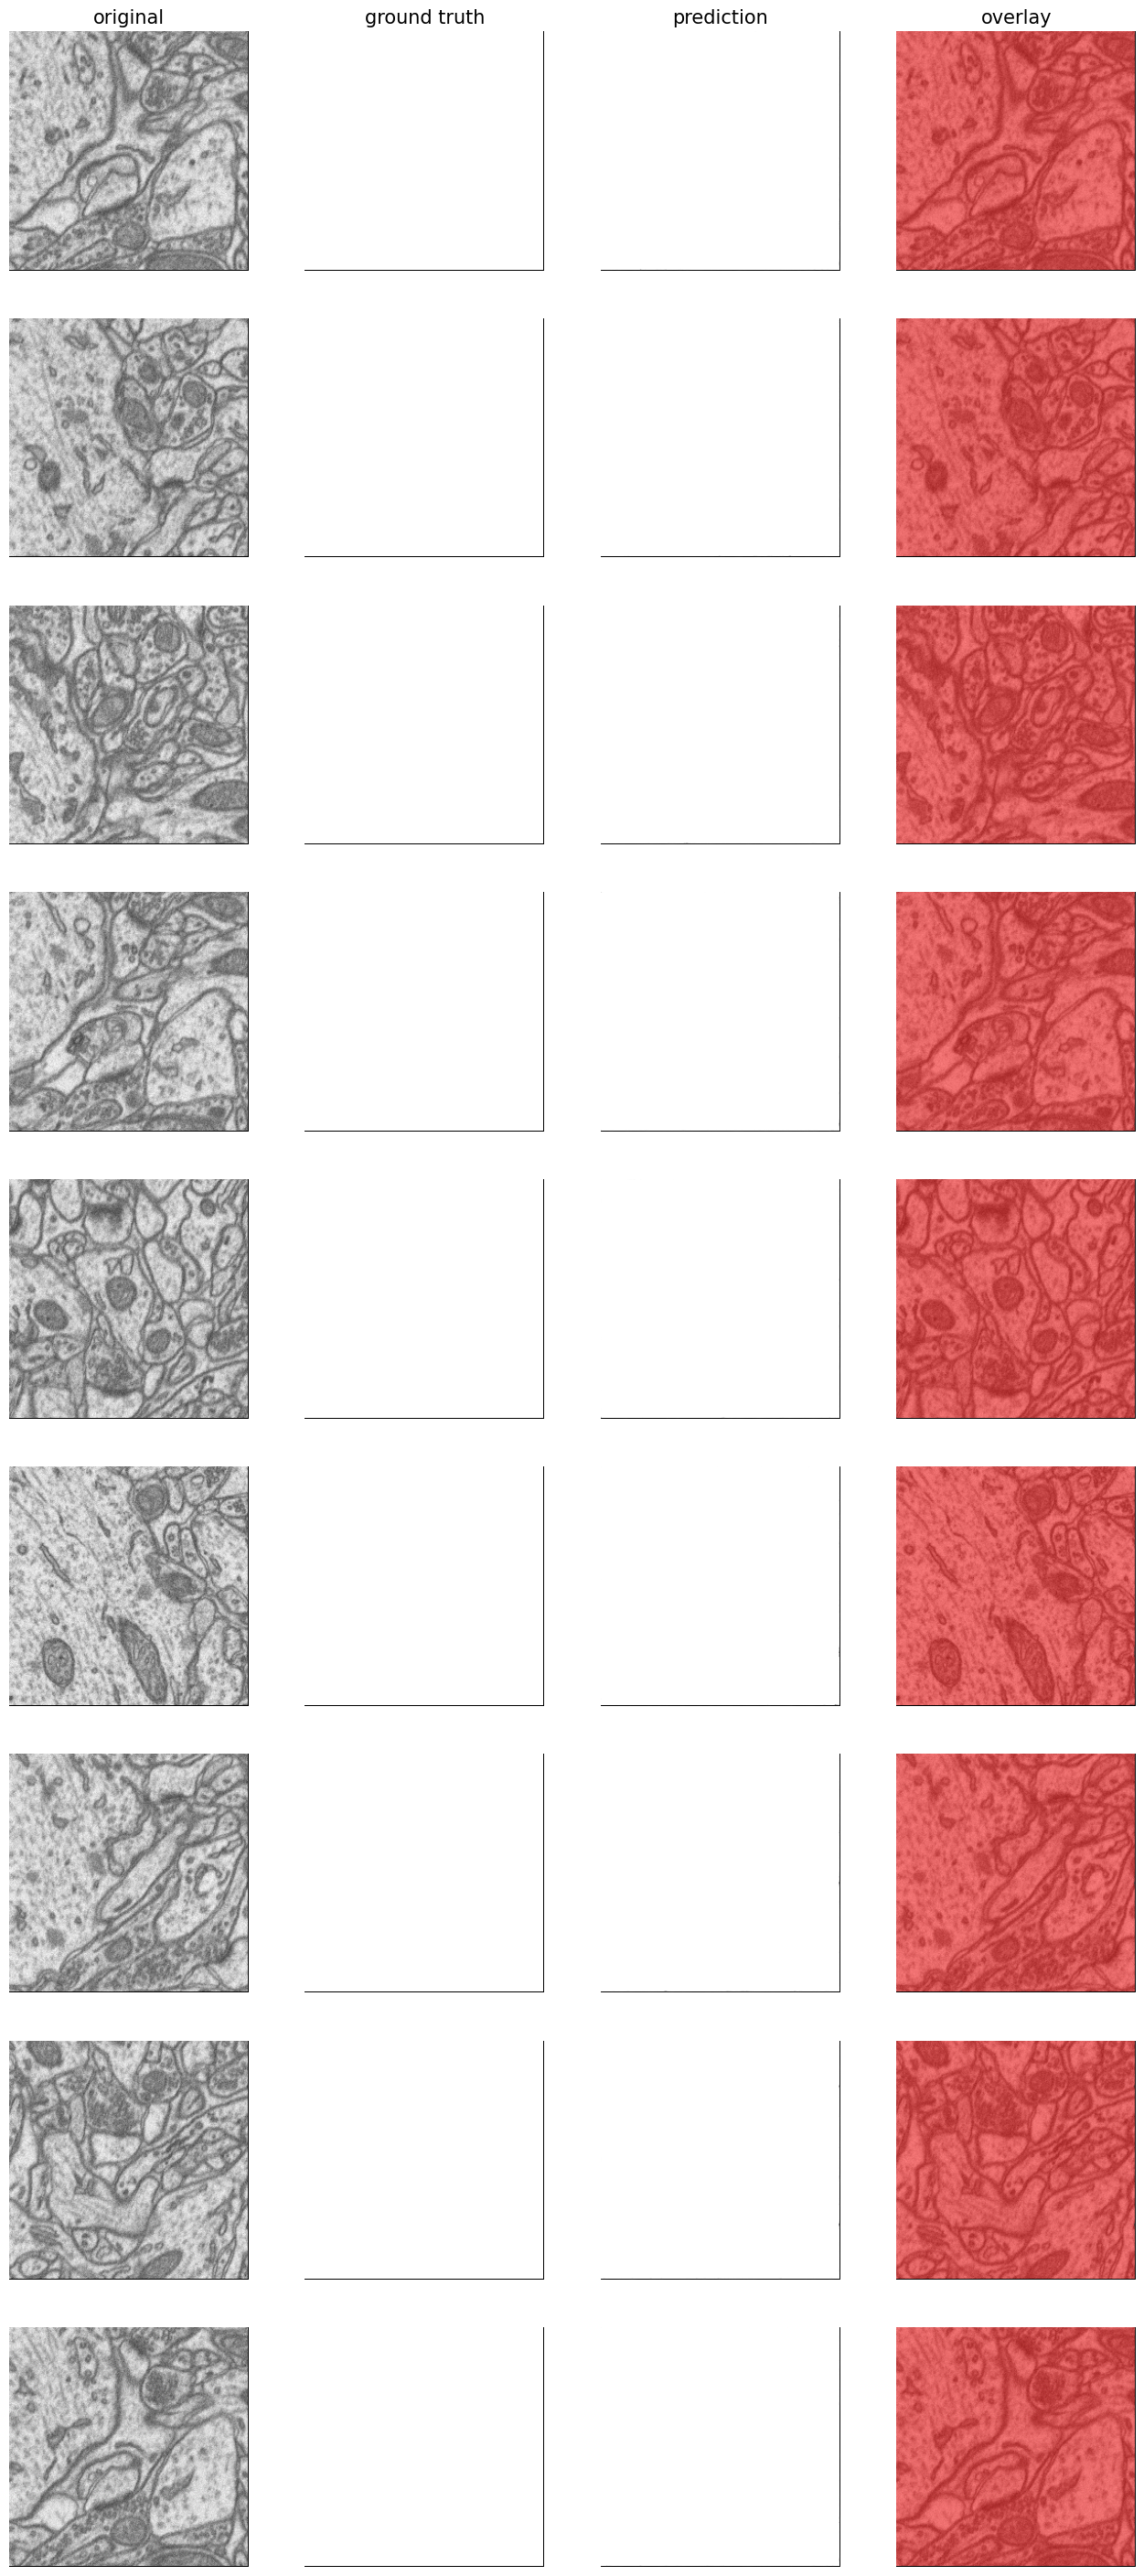

In [48]:
# ...and look at some results.
plot_imgs(org_imgs=X_test, mask_imgs=y_test, pred_imgs=y_pred, nm_img_to_plot=9)

In [49]:
import sklearn.metrics

In [50]:
# Let's use the Jaccard score to compare a thresholded
# y_pred to the groundtruth y_test.
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.9999996504840796

In [51]:
# TODO: What is the difference between Jaccard Score and Intersect-over-Union from above?
# TODO: They are both the same metric. the Jaccard score is being calculated using the sklearn.metrics.jaccard_score function to compare the thresholded y_pred to the ground truth y_test. The y_pred values are thresholded using the comparison (y_pred > 0.5), which converts them into binary values (0 or 1).

In [52]:
# TODO: Did the U-Net perform well on X_test?
# TODO: Yes, the U-Net performed well on the X_test

## 4. Combine U-Net with SAM (10 points)

In [53]:
# Instead of running SAM in auto mode without seeds (Task 1), we will now
# use the U-Net predictions on X_test to seed the SAM model.

In [54]:
# We can use the following convenience functions
# to 1) convert mahotas bounding boxes to SAM format
# and 2) combine the SAM output tensors to a mask.

In [55]:
def mahotas_bbox_to_sam(bbs):

  new_bbs = []

  for i,bb in enumerate(bbs):
    # from (y1, y2, x1, x2)
    # to (x1, y1, x2, y2)
    if i == 0:
      continue
    new_bb = [bb[2], bb[0], bb[3], bb[1]]
    new_bbs.append(new_bb)

  return new_bbs

In [56]:
def sam_to_mask(results):

  results = results.cpu() # copy back to cpu land

  mask = np.array(results[0,0])

  for s in results:
    mask[s[0] == 1] = 1

  return mask

In [57]:
# The following code combines the U-Net predictions with SAM.
#
# TODO: Please study the code and answer the TODOs in-line.

In [58]:
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  #Save the current test image as a PNG file, converting it to an 8-bit unsigned integer format.
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  #Create a binary mask of the U-Net prediction by thresholding it at 0.5.
  pred = (y_pred[z] > 0.5)

  # TODO: EXPLAIN CODE BELOW
  #Label the connected components in the binary mask.
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  #Calculate the bounding boxes for each connected component in the labeled mask.
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  #Convert the bounding box format to one that can be used by the SAM predictor.
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  #Use the SAM predictor to generate segmentation results for the input image and bounding boxes. The model_type parameter specifies the model to use (vit_l, vit_h, or vit_b).
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  #Convert the SAM segmentation results into a binary mask format.
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  #Store the combined U-Net and SAM predictions in the y_pred_sam array.
  y_pred_sam[z,:,:,0] = sam_and_unet_pred

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

## 5. Compare U-Net vs. U-Net+SAM. (10 points)

In [59]:
# U-Net performance on X_test (from Task 3)
sklearn.metrics.jaccard_score(y_test.ravel(), (y_pred > 0.5).ravel())

0.9999996504840796

In [60]:
# U-Net + SAM performance on X_test
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.9860763959196294

In [61]:
# TODO: Please explain the results - is U-Net+SAM a good addition?
# TODO: Based on the above results, the U-Net performance seems like a better option as the accuracy dropped slighlty when the U-Net + SAM model was used

## Bonus: Improve the results. (33 points)

In [62]:
# Please improve the results of U-Net+SAM and show the improved Jaccard score.

In [66]:
# TODO: YOUR_CODE
y_pred_sam = y_pred.copy()
y_pred_sam[:] = 0

for z,img in enumerate(X_test):

  # TODO: EXPLAIN CODE BELOW
  #Save the current test image as a PNG file, converting it to an 8-bit unsigned integer format.
  mh.imsave('test.png', (img[:,:,0]*255).astype(np.uint8))

  # TODO: EXPLAIN CODE BELOW
  #Create a binary mask of the U-Net prediction by thresholding it at 0.5.
  pred = (y_pred[z] > 0.7)

  # TODO: EXPLAIN CODE BELOW
  #Label the connected components in the binary mask.
  pred, _ = mh.labeled.label(pred)
  
  # TODO: EXPLAIN CODE BELOW
  #Calculate the bounding boxes for each connected component in the labeled mask.
  bbs = mh.labeled.bbox(pred)

  # TODO: EXPLAIN CODE BELOW
  #Convert the bounding box format to one that can be used by the SAM predictor.
  bbs_converted = mahotas_bbox_to_sam(bbs)

  # TODO: EXPLAIN CODE BELOW
  #Use the SAM predictor to generate segmentation results for the input image and bounding boxes. The model_type parameter specifies the model to use (vit_l, vit_h, or vit_b).
  results = SegManualMaskPredictor().image_predict(
      source="test.png",
      model_type="vit_l", # vit_l, vit_h, vit_b
      input_box=bbs_converted, 
      multimask_output=False,
      random_color=False,
      show=False,
      save=False,
  )

  # TODO: EXPLAIN CODE BELOW
  #Convert the SAM segmentation results into a binary mask format.
  sam_and_unet_pred = sam_to_mask(results)

  # TODO: EXPLAIN CODE BELOW
  #Store the combined U-Net and SAM predictions in the y_pred_sam array.
  y_pred_sam[z,:,:,0] = sam_and_unet_pred
  

vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l model already exists as 'vit_l.pth'. Skipping download.
vit_l mo

In [67]:
sklearn.metrics.jaccard_score(y_test.ravel(), y_pred_sam.ravel())

0.9860763959196294

citations: Rishank Singh

In [ ]:
#
# You made it!!
#
#                 _ ___                /^^\ /^\  /^^\_
#     _          _@)@) \            ,,/ '` ~ `'~~ ', `\.
#   _/o\_ _ _ _/~`.`...'~\        ./~~..,'`','',.,' '  ~:
#  / `,'.~,~.~  .   , . , ~|,   ,/ .,' , ,. .. ,,.   `,  ~\_
# ( ' _' _ '_` _  '  .    , `\_/ .' ..' '  `  `   `..  `,   \_
#  ~V~ V~ V~ V~ ~\ `   ' .  '    , ' .,.,''`.,.''`.,.``. ',   \_
#   _/\ /\ /\ /\_/, . ' ,   `_/~\_ .' .,. ,, , _/~\_ `. `. '.,  \_
#  < ~ ~ '~`'~'`, .,  .   `_: ::: \_ '      `_/ ::: \_ `.,' . ',  \_
#   \ ' `_  '`_    _    ',/ _::_::_ \ _    _/ _::_::_ \   `.,'.,`., \-,-,-,_,_,
#    `'~~ `'~~ `'~~ `'~~  \(_)(_)(_)/  `~~' \(_)(_)(_)/ ~'`\_.._,._,'_;_;_;_;_;
#